#데이터처리

In [ ]:
match = 0
no_match = []
length = []
for i in range(len(trains)):
  #print(f'trains[{i}] : {trains[i]}')
  #print(f'trains[{i}] : {labels[i]}')

  _, _, annotations_header = highlevel.read_edf(labels[i])
  ann = annotations_header['annotations']
  label = []
  for j in range(len(ann)):
    s = ann[j][2][0].upper()       #첫 번째 글자가 S인 것만 추출
    if s == 'S':                   #Lights off & Lights on 제거
      label.append(ann[j][2])
  signals, _, signals_header = highlevel.read_edf(trains[i],ch_names='ECG')
  signals_len = len(signals[0]) // 256 // 30 #전체 진폭데이터를 초당 256HZ로 샘플링 되었으니까 나누게 되면 이 기록데이터 하나의 시간이 나오고 그걸 30초로 나누면 한 기록데이터에서 30초 단위의 데이터가 몇개 나오는지 알 수 있다.
  annotations_len = len(label)
  #print(f'sinals_len : {signals_len}')
  #print(f'annotations_len : {annotations_len}')
  #print("\n")
  
  if signals_len == annotations_len:     # 30초 단위의 signal sample수와 label 수가 일치해야만 Train data로 사용할 수 있도록
    match += 1
    Input = signals[0]
    length_to_split = [len(Input)//signals_len]*signals_len
    signal_ = [Input[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)]
    
    for sample in range(len(signal_)):
      length.append(len(signal_[sample]))
  else :
    no_match.append((trains[i],labels[i])) 

# (초당 샘플수 (256HZ)) x 한 구간의 시간 = 256 * 30 = 7680
# => 모든 데이터들이 256HZ로 샘플링 되어 있으니 한 구간에 샘플수는 7680이 되어야 하는데 7680이 아닌 것들이 나옴
# => 해결해야될 것
# => 데이터 담기 전에 모든 signal 데이터에 대해 30초 단위로 딱 끊기게 해야됨
# => 레코딩 맨 마지막 부분에 경우 30초가 넘어 남는 부분들이 있는데 이부분 잘라내야됨
# => 7680으로 나눠서 나머지 부분 다 잘라내야되는데 이부분 어떻게 할까? ecg_signal =[:7680*(전체 샘플수 // 30초)]
print(f'num_matched : {match}')
print(f'num_no_matched : {len(no_match)}')
print(f'no_matched_list : {no_match}')
print(f'max_length  : {max(length)}')
print(f'min_length : {min(length)}')

num_matched : 146
num_no_matched : 5
no_matched_list : [('/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN001.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN001_sleepscoring.edf'), ('/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN012.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN012_sleepscoring.edf'), ('/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN047.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN047_sleepscoring.edf'), ('/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN056.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN056_sleepscoring.edf'), ('/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN121.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN121_sleepscoring.edf')]
max_length  : 7693
min_length : 7680


#Sleep_staging_classification

download libraries

In [ ]:
!pip install pyEDFlib  #pyEDFlib 라이브러리를 다운로드

In [ ]:
!pip install pyedflib

import libraries

In [ ]:
import os  
from pyedflib import highlevel
import pyedflib
import numpy as np
import glob
from itertools import accumulate
#모듈 import
from sklearn.datasets import load_iris  #(2)sklearn라이브러리에 detasets패키지 모듈 import
from sklearn.model_selection import train_test_split  #(3)sklearn.model_selection패키지의 train_test_split를 활용해 데이터셋 분리
from sklearn.tree import DecisionTreeClassifier #(4)sklearn.tree패키지에 DecisionTreeClassifier import
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score #정확도

경로 설정

In [ ]:
r_path = "/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/" #데이터들이 있는 경로

/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN001.#72번째 문자가 edf로 끝나는 경로명

SNxxx.edf로 끝나는 signal데이터와 SNxxx_sleepscoring.edf를 구분하기 위해 



In [ ]:
data_list = sorted(glob.glob(r_path+'/**')) #이름 순으로 정렬하여 r_path에 있는 데이터의 경로명들 전부 불러와 data_list에 할당

l = len(data_list[0]) - 3 #SNxxx.edf로 끝나는 signal데이터와 SNxxx_sleepscoring.edf를 구분하기 위해
                          # signal data( 예를 들어 '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN002.edf')
                          # signal data끼리는 경로명의 문자열길이가 다 같다
                          # 하지만 label data는 'sleepscoring.edf'로 끝나 signal data의 경로명과 문자열 길이가 다름
                          # signal data들만 따로 모아 리스트에 담기 위해서는 siganl data의 경로명 문자열길이에서 3을 뺀것이"edf"가 되는 것들만 모아야됨

print(f'데이터 경로 : {data_list}')
print("\n")

# signal data들의 경로를 모두 trains에 리스트에 담고, #train valid test와 헷갈리지 말 것.
# labels data들의 경로들은 모두 labels 리스트에 담는다
trains = [x for x in data_list if x.startswith('edf',l)] #뒤에서부터 세번 째 문자가 edf로 끝나면 signal 데이터 리스트에 담는다
labels = [x for x in data_list if x.endswith('_sleepscoring.edf')] #경로명이 "_sleepscoring.edf"로 끝나면 labels 리스트에 담는다

# label수 일치 하지 않는 데이터들과 그에 해당하는 label들 제거(# match 되지 않은 데이터 : SN001 SN012 SN047 SN056 SN121)
# 151명 전체 사용하려면 이부분 다 지우던지 주석처리
trains.remove(r_path+'SN001.edf')
trains.remove(r_path+'SN012.edf')
trains.remove(r_path+'SN047.edf')
trains.remove(r_path+'SN056.edf')
trains.remove(r_path+'SN121.edf')
labels.remove(r_path+'SN001_sleepscoring.edf')
labels.remove(r_path+'SN012_sleepscoring.edf')
labels.remove(r_path+'SN047_sleepscoring.edf')
labels.remove(r_path+'SN056_sleepscoring.edf')
labels.remove(r_path+'SN121_sleepscoring.edf')

# ram 과부하로 인해 100개 데이터만 사용 하려면 주석처리 x
#trains = trains[:100]
#labels = labels[:100]

print(f'signal_data 경로 : {trains}')
print("\n")
print(f'label_data 경로 : {labels}')
print("\n")
print(f"첫번째 데이터 : {highlevel.read_edf(trains[0],ch_names='ECG')}")
print("\n")
print(f'첫번째 label data : {highlevel.read_edf(labels[0])}')
#print(highlevel.read_edf(trains[0],ch_names='ECG',digital=True))
#a = highlevel.read_edf(trains[0],ch_names='ECG')
#b = highlevel.read_edf(labels[0],ch_names='ECG')
#print(type(highlevel.read_edf(trains[0])))
#print(type(highlevel.read_edf(labels[0])))

print(f"Total signal count: {len(trains)}")
#print(f"Label names: {class_names}")
print(f"Label counts: {len(labels)}")

데이터 경로 : ['/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN001.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN001_sleepscoring.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN001_sleepscoring.txt', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN002.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN002_sleepscoring.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN002_sleepscoring.txt', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN003.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN003_sleepscoring.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN003_sleepscoring.txt', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN004.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN004_sleepscoring.edf', '/content/drive/MyDrive/physio

In [ ]:
val_frac = 0.1 # 전체 데이터 중 valid data의 비율
test_frac = 0.1 # 전체 데이터 중 test data의 비율
length = len(trains) # 전체 데이터의 수
indices = np.arange(length) # ndarray를 생성 length=3으로 설정하면 -> array([0,1,2])가 리턴 됨
np.random.shuffle(indices) #배열순서를 random하게 섞음 -> [SN045, SN075, SN112,...] 이런 식으로 섞이도록

test_split = int(test_frac * length) #전체데이터수의 10%에 해당하는 수를 저장
val_split = int(val_frac * length) + test_split #10%에 해당하는 데이터와 test data수를 합친 수를 저장  
test_indices = indices[:test_split] #0부터 test_split 수만큼 전체 원소에서 원소 추출
val_indices = indices[test_split:val_split] #testsplite의 마지막 원소부터 val_split의수 만큼의 원소를 추출
train_indices = indices[val_split:] # 나머지 인덱스에 해당하는 원소를 모두 train_indices로 저장

train_x = [trains[i] for i in train_indices] # signal data들(trains리스트)로부터 인덱싱을 통해 train 데이터셋 추출
train_y = [labels[i] for i in train_indices]      # label data들(labels리스트)로부터 train 데이터에 대한 레이블데이터 추출
val_x = [trains[i] for i in val_indices]     # signal data들(trains리스트)로부터 인덱싱을 통해 valid 데이터셋 추출
val_y = [labels[i] for i in val_indices]          # label data들(labels리스트)로부터 valid 데이터에 대한 레이블데이터 추출
test_x = [trains[i] for i in test_indices]   # signal data들(trains리스트) 인덱싱을 통해 test 데이터셋 추출
test_y = [labels[i] for i in test_indices]        # label data들(labels리스트)로부터 test 데이터에 대한 레이블데이터 추출

# train,valid,test 각 데이터의 수 출력
print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 118, Validation count: 14, Test count: 14


In [ ]:
print(f'train_x : {train_x[3]}')
print(f'train_y : {train_y[3]}')

train_x : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN101.edf
train_y : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN101_sleepscoring.edf


In [ ]:
# Prepare training, validation and test data lists (min_length)
# max_length  : 7693 , min_length : 7680
# length : 한 구간(30초)에서의 sample(진폭)data의 수
max_length  = 7693
min_length = 7680

Train_x = []
Train_y = []
Val_x = []
Val_y = []
Test_x = []
Test_y = []

train_no_match = []
train_match = 0
val_no_match = []
val_match = 0
test_no_match = []
test_match = 0


#tain data 준비

for i in range(len(train_x)):
  print(f'train_x[{i}] : {train_x[i]}')
  print(f'train_y[{i}] : {train_y[i]}')

  _, _, annotations_header = highlevel.read_edf(train_y[i])
  ann = annotations_header['annotations']
  label = []
  for j in range(len(ann)):
    s = ann[j][2][0].upper()       #첫 번째 글자가 S인 것만 추출
    if s == 'S':                   #Lights off & Lights on 제거
      label.append(ann[j][2])
  signals, _, signals_header = highlevel.read_edf(train_x[i],ch_names='ECG')
  signals_len = len(signals[0]) // 256 // 30 #전체 진폭데이터(샘플)를 초당 256HZ로 샘플링 되었으니까 256으로 나누게 되면 이 기록데이터 하나의 시간이 나오고 그걸 30초로 나누면 한 기록데이터에서 30초 단위의 데이터가 몇 개 나오는지 알 수 있다.
  annotations_len = len(label)
  print(f'sinals_len : {signals_len}')
  print(f'annotations_len : {annotations_len}')
  print("\n")
  
  if signals_len == annotations_len:     # 30초 단위의 signal sample수와 label 수가 일치해야만 Train data로 사용할 수 있도록
    train_match += 1
    Input = signals[0]
    length_to_split = [len(Input)//signals_len]*signals_len
    signal_ = [Input[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)]
    
    for sample in range(len(signal_)):
      Train_x.append(signal_[sample][:min_length])
      Train_y.append(label[sample])
  else :
    train_no_match.append((train_x[i],train_y[i])) 

print(f'num_train_matched : {train_match}')
print(f'num_train_no_matched : {len(train_no_match)}')
print(f'train_no_matched_list : {train_no_match}')


#valid data 준비

for i in range(len(val_x)):
  print(f'val_x[{i}] : {val_x[i]}')
  print(f'val_y[{i}] : {val_y[i]}')

  _, _, annotations_header = highlevel.read_edf(val_y[i])
  ann = annotations_header['annotations']
  label = []
  for j in range(len(ann)):
    s = ann[j][2][0].upper()       #첫 번째 글자가 S인 것만 추출
    if s == 'S':                   #Lights off & Lights on 제거
      label.append(ann[j][2])
  signals, _, signals_header = highlevel.read_edf(val_x[i],ch_names='ECG')
  signals_len = len(signals[0]) // 256 // 30 #전체 진폭데이터를 초당 256HZ로 샘플링 되었으니까 나누게 되면 이 기록데이터 하나의 시간이 나오고 그걸 30초로 나누면 한 기록데이터에서 30초 단위의 데이터가 몇개 나오는지 알 수 있다.
  annotations_len = len(label)
  print(f'sinals_len : {signals_len}')
  print(f'annotations_len : {annotations_len}')
  print("\n")
  
  if signals_len == annotations_len:     # 30초 단위의 signal sample수와 label 수가 일치해야만 Train data로 사용할 수 있도록
    val_match += 1
    Input = signals[0]
    length_to_split = [len(Input)//signals_len]*signals_len
    signal_ = [Input[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)]
    
    for sample in range(len(signal_)):
      Val_x.append(signal_[sample][:min_length])
      Val_y.append(label[sample])
  else :
    val_no_match.append((val_x[i],val_y[i])) 

print(f'num_val_matched : {val_match}')
print(f'num_val_no_matched : {len(val_no_match)}')
print(f'val_no_matched_list : {val_no_match}')


#test data 준비

for i in range(len(test_x)):

  _, _, annotations_header = highlevel.read_edf(test_y[i])
  ann = annotations_header['annotations']
  label = []
  for j in range(len(ann)):
    s = ann[j][2][0].upper()       #첫 번째 글자가 S인 것만 추출
    if s == 'S':                   #Lights off & Lights on 제거
      label.append(ann[j][2])
  signals, _, signals_header = highlevel.read_edf(test_x[i],ch_names='ECG')
  signals_len = len(signals[0]) // 256 // 30 #전체 진폭데이터를 초당 256HZ로 샘플링 되었으니까 나누게 되면 이 기록데이터 하나의 시간이 나오고 그걸 30초로 나누면 한 기록데이터에서 30초 단위의 데이터가 몇개 나오는지 알 수 있다.
  annotations_len = len(label)
  
  if signals_len == annotations_len:     # 30초 단위의 signal sample수와 label 수가 일치해야만 Train data로 사용할 수 있도록
    test_match += 1
    Input = signals[0]
    length_to_split = [len(Input)//signals_len]*signals_len
    signal_ = [Input[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)]
    
    for sample in range(len(signal_)):
      Test_x.append(signal_[sample][:min_length])
      Test_y.append(label[sample])
  else :
    test_no_match.append((test_x[i],test_y[i])) 

print(f'num_test_matched : {test_match}')
print(f'num_test_no_matched : {len(test_no_match)}')
print(f'test_no_matched_list : {test_no_match}')

train_x[0] : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN049.edf
train_y[0] : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN049_sleepscoring.edf
sinals_len : 801
annotations_len : 801


train_x[1] : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN036.edf
train_y[1] : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN036_sleepscoring.edf
sinals_len : 808
annotations_len : 808


train_x[2] : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN028.edf
train_y[2] : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN028_sleepscoring.edf
sinals_len : 902
annotations_len : 902


train_x[3] : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN101.edf
train_y[3] : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN101_sleepscoring.edf
sinals_len : 919
annotations_len : 919


train_x[4] : /content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/reco

In [ ]:
# result

print(f'train_num_matched : {train_match}')
print(f'train_num_no_matched : {len(train_no_match)}')
print(f'train_no_matched_list : {train_no_match}')
print(f'num_val_matched : {val_match}')
print(f'num_val_no_matched : {len(val_no_match)}')
print(f'val_no_matched_list : {val_no_match}')
print(f'num_test_matched : {test_match}')
print(f'num_test_no_matched : {len(test_no_match)}')
print(f'test_no_matched_list : {test_no_match}')
print(f'total_num_matched : {train_match + val_match + test_match}')
print(f'total_num_no_matched : {len(train_no_match) + len(val_no_match) + len(test_no_match)}')

# match 되지 않은 데이터 : SN012 SN001 SN121 SN056 SN047

NameError: ignored

1개에 대해 전처리
(이 코드들 기반으로 위에서 전체 데이터에 대해 전처리 과정 수행)

실행할 필요 없음

In [ ]:
_, _, annotations_header = highlevel.read_edf(labels[27])
ann = annotations_header['annotations']
print(ann)
print(ann[0][2])
label = []
for i in range(len(ann)):
  j = ann[i][2][0].upper()
  if j == 'S':                   #Lights off & Lights on 제거
    label.append(ann[i][2])

[[0.0, 30.0, 'Sleep stage W'], [30.0, 30.0, 'Sleep stage W'], [32.4, 0.0, 'Lights off@@SaO2'], [60.0, 30.0, 'Sleep stage W'], [90.0, 30.0, 'Sleep stage W'], [120.0, 30.0, 'Sleep stage W'], [150.0, 30.0, 'Sleep stage W'], [180.0, 30.0, 'Sleep stage W'], [210.0, 30.0, 'Sleep stage W'], [240.0, 30.0, 'Sleep stage W'], [270.0, 30.0, 'Sleep stage W'], [300.0, 30.0, 'Sleep stage W'], [330.0, 30.0, 'Sleep stage W'], [360.0, 30.0, 'Sleep stage W'], [390.0, 30.0, 'Sleep stage W'], [420.0, 30.0, 'Sleep stage W'], [450.0, 30.0, 'Sleep stage W'], [480.0, 30.0, 'Sleep stage W'], [510.0, 30.0, 'Sleep stage W'], [540.0, 30.0, 'Sleep stage W'], [570.0, 30.0, 'Sleep stage W'], [600.0, 30.0, 'Sleep stage W'], [630.0, 30.0, 'Sleep stage W'], [660.0, 30.0, 'Sleep stage W'], [690.0, 30.0, 'Sleep stage W'], [720.0, 30.0, 'Sleep stage N1'], [750.0, 30.0, 'Sleep stage W'], [780.0, 30.0, 'Sleep stage W'], [810.0, 30.0, 'Sleep stage W'], [840.0, 30.0, 'Sleep stage W'], [870.0, 30.0, 'Sleep stage W'], [900.0, 30

In [ ]:
signals, _, signals_header = highlevel.read_edf(trains[27],ch_names='ECG')
print(f'signals={signals}')
print(f'label={label}')
print(len(signals[0]))
signals_len = len(signals[0]) // 256 // 30 #전체 진폭데이터를 초당 256HZ로 샘플링 되었으니까 나누게 되면 이 기록데이터 하나의 시간이 나오고 그걸 30초로 나누면 한 기록데이터에서 30초 단위의 데이터가 몇개 나오는지 알 수 있다.
annotations_len = len(label)
print(f'signals_len : {signals_len}')
print(f'annotations_len : {annotations_len}')
print(signals_header['startdate'])
print(annotations_header['startdate'])
signals = np.array(signals)
print(trains[27])

signals=[[-4.95161364e+02 -3.51604486e+02 -2.39322499e+02 ... -3.66216526e-02
  -3.66216526e-02 -3.66216526e-02]]
label=['Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage N1', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage W', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N2', 'Sleep stage N1', 'Sleep stage W', 'Sleep stage W', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage N1', 'Sleep stage 

In [ ]:
print(5936896//256)
print(23191//30)

23191
773


In [ ]:
256*30
#for i in range(len(len(signals_len))):

Input = signals[0]
length_to_split = [len(Input)//signals_len]*signals_len
signal_ = [Input[x - y: x] for x, y in zip(
          accumulate(length_to_split), length_to_split)]
print("Initial list :", len(Input))
print("After splitting", (len(signal_)))
#print("Initial list :", (Input))
#print("After splitting", ((signal_)))
#print(signal_)
#signal_ = np.array(signal_)
#print(signal_)

Initial list : 7649536
After splitting 996


scikit-learn 분류모델

In [ ]:
#print(np.shape(Train_x))
#print(np.shape(Train_y))
#print(np.shape(signal_))
#print(np.shape(label))

In [ ]:
len(Train_x[5000])

7680

In [ ]:
 #train, test 데이터 분리
 #X:feature데이터만 / y:정답label데이터만 
 #X데이터셋을 머신러닝 모델에 입력 -> 모델이 내뱉는 품종 예측 결과를 정답 y와 비교하여 학습
X_train, X_test, y_train, y_test = train_test_split(signal_,  #feature(입력받는 특징 데이터)
                                                    label,  #label(모델이 맞춰야하는 정답값)
                                                    test_size=0.1,  #test dataset 크기 조절(0.2=전체 20%를 test데이터로 사용)
                                                    random_state=7)  #train데이터와 test데이터 분리시 적용되는 랜덤성)

In [ ]:
# (4)decision tree 모델 학습 및 예측
decision_tree = DecisionTreeClassifier(random_state=32) #decision_tree변수에 모델 저장
decision_tree.fit(Train_x, Train_y) #fit메서드로 모델 학습

#inference

y_pred = decision_tree.predict(Test_x)

print(classification_report(Test_y, y_pred))

                precision    recall  f1-score   support

Sleep stage N1       0.10      0.13      0.12       857
Sleep stage N2       0.39      0.35      0.37      3245
Sleep stage N3       0.22      0.17      0.19      1882
 Sleep stage R       0.16      0.17      0.17      1346
 Sleep stage W       0.15      0.19      0.17      1125

      accuracy                           0.24      8455
     macro avg       0.20      0.20      0.20      8455
  weighted avg       0.25      0.24      0.24      8455



In [ ]:
#Stochastic Gradient Descent Classifier (SGDClassifier)
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier()
sgd_model.fit(Train_x, Train_y)
y_pred = sgd_model.predict(Test_x)

print(classification_report(Test_y, y_pred))

                precision    recall  f1-score   support

Sleep stage N1       0.10      0.12      0.11       857
Sleep stage N2       0.39      0.32      0.35      3245
Sleep stage N3       0.22      0.20      0.21      1882
 Sleep stage R       0.16      0.21      0.18      1346
 Sleep stage W       0.14      0.14      0.14      1125

      accuracy                           0.23      8455
     macro avg       0.20      0.20      0.20      8455
  weighted avg       0.25      0.23      0.24      8455



In [ ]:
#Support Vector Machine (SVM)
#Support Vector와 Hyperplane(초평면)을 이용해서 분류를 수행하게 되는 대표적인 선형 분류 알고리즘

from sklearn import svm

svm_model = svm.SVC()
svm_model.fit(Train_x, Train_y)
y_pred = svm_model.predict(Test_x)

print(classification_report(Test_y, y_pred))

In [ ]:
#Logistic Regression
#소프트맥스(softmas) 함수를 사용한 다중 클래스 분류 알고리즘
#이름은 회귀지만, 실제로는 분류를 수행

from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(Train_x, Train_y)
y_pred = logistic_model.predict(Test_x)

print(classification_report(Test_y, y_pred))

NameError: ignored

In [ ]:
Taccuracy = accuracy_score(y_test, y_pred)
accuracy   

0.21935483870967742

시각화

['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2', 'EMG chin', 'EOG E1-M2', 'EOG E2-M2', 'ECG']
Duaration:23191
Freq.:[256 256 256 256 256 256 256 256]
N-Sample(=Freq x Duaration):[5936896 5936896 5936896 5936896 5936896 5936896 5936896 5936896]
Date:2001-01-01 00:49:00


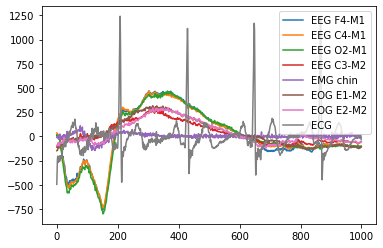

In [ ]:
edf = pyedflib.EdfReader(trains[0])
Labels = edf.getSignalLabels()
print(Labels)
print("Duaration:"+str(edf.getFileDuration()))
print("Freq.:"+str(edf.getSampleFrequencies()))
print("N-Sample(=Freq x Duaration):"+str(edf.getNSamples()))
print("Date:"+str(edf.getStartdatetime()))

#sample의 개수는 frequecncy * duration 이다
#초당 256개의 진폭 값이 있고 그것이 duration 만큼 있는 것이니



plt.plot(edf.readSignal(0)[0:1000],label=labels[0])
plt.plot(edf.readSignal(1)[0:1000],label=labels[1])
plt.plot(edf.readSignal(2)[0:1000],label=labels[2])
plt.plot(edf.readSignal(3)[0:1000],label=labels[3])
plt.plot(edf.readSignal(4)[0:1000],label=labels[4])
plt.plot(edf.readSignal(5)[0:1000],label=labels[5])
plt.plot(edf.readSignal(6)[0:1000],label=labels[6])
plt.plot(edf.readSignal(7)[0:1000],label=labels[7])
plt.legend()
plt.show()

#----

In [ ]:
label = []
if ann[2] == 'Sleep stage W':
  for time in range(length):
    label.append(0)
    elif ann[2] == 'Sleep stage 1':
            for time in range(length):
                label.append(1)
        elif ann[2] == 'Sleep stage 2':
            for time in range(length):
                label.append(2)
        elif ann[2] == 'Sleep stage 3':
            for time in range(length):
                label.append(3)
        elif ann[2] == 'Sleep stage 4':
            for time in range(length):
                label.append(3)
        elif ann[2] == 'Sleep stage R':
            for time in range(length):
                label.append(4)
        else:
            for time in range(length):
                label.append(5)
    label = np.array(label)

In [ ]:
a = highlevel.read_edf(trains[0],ch_names='ECG')
b = highlevel.read_edf(labels[0])
print(type(a))
a = list(a)
b = list(b)
print(a)
print(len(a[0][0]))
print(a[0])
print(b)
a = a[0]
b = b[2]
print(a)
print(b)
print(len(a))
print(b)


<class 'tuple'>
5936896
[[-4.95161364e+02 -3.51604486e+02 -2.39322499e+02 ... -3.66216526e-02
  -3.66216526e-02 -3.66216526e-02]]
[array([], dtype=float64), [], {'technician': '', 'recording_additional': '', 'patientname': 'X', 'patient_additional': '', 'patientcode': 'SN031', 'equipment': '', 'admincode': '', 'gender': '', 'startdate': datetime.datetime(2001, 1, 1, 0, 49), 'birthdate': '', 'annotations': [[0.0, 30.0, 'Sleep stage W'], [30.0, 30.0, 'Sleep stage W'], [32.4, 0.0, 'Lights off@@SaO2'], [60.0, 30.0, 'Sleep stage W'], [90.0, 30.0, 'Sleep stage W'], [120.0, 30.0, 'Sleep stage W'], [150.0, 30.0, 'Sleep stage W'], [180.0, 30.0, 'Sleep stage W'], [210.0, 30.0, 'Sleep stage W'], [240.0, 30.0, 'Sleep stage W'], [270.0, 30.0, 'Sleep stage W'], [300.0, 30.0, 'Sleep stage W'], [330.0, 30.0, 'Sleep stage W'], [360.0, 30.0, 'Sleep stage W'], [390.0, 30.0, 'Sleep stage W'], [420.0, 30.0, 'Sleep stage W'], [450.0, 30.0, 'Sleep stage W'], [480.0, 30.0, 'Sleep stage W'], [510.0, 30.0, 'Sle

In [ ]:
edf = pyedflib.EdfReader(trains[0])
print(edf)

In [ ]:
f = pyedflib.data.test_generator()
print(f.readSignal(0))
print(edf.readSignal(7))

[ 99.99237049  99.99237049  99.99237049 ... -99.96185245 -99.96185245
 -99.96185245]
[-8.53284504 20.91096361  7.58068208 ... -0.03662165 -0.03662165
 -0.03662165]


In [ ]:
print(trains)

['/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN031.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN032.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN033.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN034.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN035.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN036.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN037.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN038.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN039.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN040.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN041.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-staging/recordings/SN042.edf', '/content/drive/MyDrive/physionet/HMC/hmc-sleep-sta

In [ ]:
f = pyedflib.EdfReader(trains[47])
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)

In [ ]:
print((len(sigbufs[7])))
print(sigbufs[7])#

8583680
[-9.33485924e+01 -7.11558709e+01 -1.20888075e+02 ... -3.66216526e-02
 -3.66216526e-02 -3.66216526e-02]


In [ ]:
edfl = pyedflib.EdfReader(labels[0])
print("Anotation:"+str(edfl.read_annotation()))
print(len(edfl.read_annotation()))

Anotation:[[0, b'30', b'Sleep stage W'], [300000000, b'30', b'Sleep stage W'], [324000000, b'0', b'Lights off@@SaO2'], [600000000, b'30', b'Sleep stage W'], [900000000, b'30', b'Sleep stage W'], [1200000000, b'30', b'Sleep stage W'], [1500000000, b'30', b'Sleep stage W'], [1800000000, b'30', b'Sleep stage W'], [2100000000, b'30', b'Sleep stage W'], [2400000000, b'30', b'Sleep stage W'], [2700000000, b'30', b'Sleep stage W'], [3000000000, b'30', b'Sleep stage W'], [3300000000, b'30', b'Sleep stage W'], [3600000000, b'30', b'Sleep stage W'], [3900000000, b'30', b'Sleep stage W'], [4200000000, b'30', b'Sleep stage W'], [4500000000, b'30', b'Sleep stage W'], [4800000000, b'30', b'Sleep stage W'], [5100000000, b'30', b'Sleep stage W'], [5400000000, b'30', b'Sleep stage W'], [5700000000, b'30', b'Sleep stage W'], [6000000000, b'30', b'Sleep stage W'], [6300000000, b'30', b'Sleep stage W'], [6600000000, b'30', b'Sleep stage W'], [6900000000, b'30', b'Sleep stage W'], [7200000000, b'30', b'Sle

In [ ]:
(1초당 256개의 진폭데이터)가 60 0000000

#기타

In [ ]:
!pip install mne  
!pip install mne.io

     |████████████████████████████████| 7.5 MB 25.9 MB/s 
ERROR: Could not find a version that satisfies the requirement mne.io (from versions: none)
ERROR: No matching distribution found for mne.io


ERROR: Could not find a version that satisfies the requirement dhedfreader (from versions: none)
ERROR: No matching distribution found for dhedfreader


In [ ]:
import argparse
import glob
import math
import ntpath
import os
import shutil
import urllib.request, urllib.parse, urllib.error
import urllib.request, urllib.error, urllib.parse

from datetime import datetime

import numpy as np

from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf

import dhedfreader


# Label values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

stage_dict = {
    "W": W,
    "N1": N1,
    "N2": N2,
    "N3": N3,
    "REM": REM,
    "UNKNOWN": UNKNOWN
}

class_dict = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM",
    5: "UNKNOWN"
}

ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}

EPOCH_SEC_SIZE = 30


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_dir", type=str, default="/content/drive/MyDrive/HMC",
                        help="File path to the CSV or NPY file that contains walking data.")
    parser.add_argument("--output_dir", type=str, default="/content/drive/MyDrive/HMC/HMC_output",
                        help="Directory where to save outputs.")
    parser.add_argument("--select_ch", type=str, default="ECG",
                        help="File path to the trained model used to estimate walking speeds.")
    args = parser.parse_args()

    # Output dir
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)
    else:
        shutil.rmtree(args.output_dir)
        os.makedirs(args.output_dir)

    # Select channel
    select_ch = args.select_ch

    # Read raw and annotation EDF files
    psg_fnames = glob.glob(os.path.join(args.data_dir, "*.edf"))
    ann_fnames = glob.glob(os.path.join(args.data_dir, "*sleepscoring.edf"))
    psg_fnames.sort()
    ann_fnames.sort()
    psg_fnames = np.asarray(psg_fnames)
    ann_fnames = np.asarray(ann_fnames)

    for i in range(len(psg_fnames)):
        # if not "ST7171J0-PSG.edf" in psg_fnames[i]:
        #     continue

        raw = read_raw_edf(psg_fnames[i], preload=True, stim_channel=None)
        sampling_rate = raw.info['sfreq']
        raw_ch_df = raw.to_data_frame(scaling_time=100.0)[select_ch]
        raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))

        # Get raw header
        f = open(psg_fnames[i], 'r', encoding='iso-8859-1')
        reader_raw = dhedfreader.BaseEDFReader(f)
        reader_raw.read_header()
        h_raw = reader_raw.header
        f.close()
        raw_start_dt = datetime.strptime(h_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # Read annotation and its header
        f = open(ann_fnames[i], 'r', encoding='iso-8859-1')
        reader_ann = dhedfreader.BaseEDFReader(f)
        reader_ann.read_header()
        h_ann = reader_ann.header
        _, _, ann = list(zip(*reader_ann.records()))
        f.close()
        ann_start_dt = datetime.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

        # Assert that raw and annotation files start at the same time
        assert raw_start_dt == ann_start_dt

        # Generate label and remove indices
        remove_idx = []    # indicies of the data that will be removed
        labels = []        # indicies of the data that have labels
        label_idx = []
        for a in ann[0]:
            onset_sec, duration_sec, ann_char = a
            ann_str = "".join(ann_char)
            label = ann2label[ann_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Something wrong")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=np.int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                label_idx.append(idx)

                print("Include onset:{}, duration:{}, label:{} ({})".format(
                    onset_sec, duration_sec, label, ann_str
                ))
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                remove_idx.append(idx)

                print("Remove onset:{}, duration:{}, label:{} ({})".format(
                    onset_sec, duration_sec, label, ann_str
                ))
        labels = np.hstack(labels)
        
        print("before remove unwanted: {}".format(np.arange(len(raw_ch_df)).shape))
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))
        print("after remove unwanted: {}".format(select_idx.shape))

        # Select only the data with labels
        print("before intersect label: {}".format(select_idx.shape))
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)
        print("after intersect label: {}".format(select_idx.shape))

        # Remove extra index
        if len(label_idx) > len(select_idx):
            print("before remove extra labels: {}, {}".format(select_idx.shape, labels.shape))
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # Trim the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]
            print("after remove extra labels: {}, {}".format(select_idx.shape, labels.shape))

        # Remove movement and unknown stages if any
        raw_ch = raw_ch_df.values[select_idx]

        # Verify that we can split into 30-s epochs
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Something wrong")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # Get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)

        assert len(x) == len(y)

        # Select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != stage_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        print(("Data before selection: {}, {}".format(x.shape, y.shape)))
        x = x[select_idx]
        y = y[select_idx]
        print(("Data after selection: {}, {}".format(x.shape, y.shape)))

        # Save
        filename = ntpath.basename(psg_fnames[i]).replace("-PSG.edf", ".npz")
        save_dict = {
            "x": x, 
            "y": y, 
            "fs": sampling_rate,
            "ch_label": select_ch,
            "header_raw": h_raw,
            "header_annotation": h_ann,
        }
        np.savez(os.path.join(args.output_dir, filename), **save_dict)

        print("\n=======================================\n")


if __name__ == "__main__":
    main()

ModuleNotFoundError: ignored

#Importing libraries and initializing variables

In [ ]:
!pip install edfreader

ERROR: Could not find a version that satisfies the requirement edfreader (from versions: none)
ERROR: No matching distribution found for edfreader


In [ ]:
%matplotlib inline

import glob
import math
import ntpath
import random, os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import edfreader
import models
import mne
import pyeeg
import warnings
warnings.filterwarnings('ignore')

from matplotlib.backends.backend_pdf import PdfPages
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS, _check_subjects
from datetime import datetime
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import FunctionTransformer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
# from tensorflow.keras import optimizers, losses
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation, SpatialDropout1D, GlobalMaxPool1D
# from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
# from tensorflow.keras.layers import concatenate
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.externals import joblib
# from sklearn.preprocessing import StandardScaler
# from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, log_loss
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_auc_score, roc_curve
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

VBS = True  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 42  # seed value for the random seeds
batch_size = 64
number_of_subj = 50

# values to label the stages
UNKNOWN = -1
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4

# making string dictionary for the label values
label_dict = {
    "UNKNOWN"  : UNKNOWN,
    "W"        : W,
    "N1"       : N1,
    "N2"       : N2,
    "N3"       : N3,
    "REM"      : REM
}

# converting from label values to strings 
class_dict = {
    -1: "UNKNOWN",
    0 : "W",
    1 : "N1",
    2 : "N2",
    3 : "N3",
    4 : "REM"
}

# annotation dictionary to convert from string to label values
annot2label = {
    "Sleep stage ?": -1,
    "Movement time": -1,
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4
}
project_path = os.path.abspath(os.getcwd())  # finding the current project path in windows

ModuleNotFoundError: ignored

Localizing fetch_data function to import all subjects


In [ ]:
# localized fetch_data function by using mne library
# https://github.com/mne-tools/mne-python/blob/maint/0.20/mne/datasets/sleep_physionet/age.py#L18-L111
data_path = _data_path
BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'
def fetch_data(subjects, recording=[1, 2], path=None, force_update=False,
               update_path=None, base_url=BASE_URL,
               verbose=None):  # noqa: D301
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path, update_path=update_path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = _fetch_one(psg_records['fname'][idx].decode(),
                                       psg_records['sha'][idx].decode(),
                                       *params)
                hyp_fname = _fetch_one(hyp_records['fname'][idx].decode(),
                                       hyp_records['sha'][idx].decode(),
                                       *params)
                fnames.append([psg_fname, hyp_fname])

    return fnames

NameError: ignored

In [ ]:
path = '/content/drive/MyDrive/HMC/'

#test_images = sorted(
#    glob.glob(os.path.join(data_dir,)))
#data_list = sorted(glob.glob(os.path.join(path,"SN*",".edf")))
data_list = glob.glob(path+'/**')
print(data_list)

trains=[]
labels=[]
trains = [x for x in data_list if x.startswith('edf',33)]
labels = [x for x in data_list if x.endswith('_sleepscoring.edf')]
print(trains)
print("#########")
print(labels)
print("#########")
print(highlevel.read_edf(trains[0]))
print(highlevel.read_edf(labels[0]))
signals, _, signals_header = highlevel.read_edf(trains[0],ch_names='ECG')
print(f'signals={signals}')
print(len(signals[0]))

['/content/drive/MyDrive/HMC/SN001_sleepscoring.edf', '/content/drive/MyDrive/HMC/SN001.edf']
['/content/drive/MyDrive/HMC/SN001.edf']
#########
['/content/drive/MyDrive/HMC/SN001_sleepscoring.edf']
#########
(array([[ 1.71267262e+01,  1.82253758e+01,  1.75906004e+01, ...,
        -1.22072175e-02, -1.22072175e-02, -1.22072175e-02],
       [ 1.47585260e+01,  1.55642023e+01,  1.06324865e+01, ...,
        -1.22072175e-02, -1.22072175e-02, -1.22072175e-02],
       [ 3.83428702e+01,  3.71221485e+01,  2.41092546e+01, ...,
        -1.22072175e-02, -1.22072175e-02, -1.22072175e-02],
       ...,
       [ 3.74761578e+00,  1.09987030e+01,  2.16433967e+01, ...,
        -1.22072175e-02, -1.22072175e-02, -1.22072175e-02],
       [-9.28969253e+00, -1.09010452e+01, -9.50942245e+00, ...,
        -1.22072175e-02, -1.22072175e-02, -1.22072175e-02],
       [ 7.37193866e+01,  7.09361410e+01,  6.93980316e+01, ...,
        -3.66216526e-02, -3.66216526e-02, -3.66216526e-02]]), [{'label': 'EEG F4-M1', 'dimensi